**Scene:**

Its 3pm and your supervisor has just handed you their old Fortran77 code that they swear "solved this problem in the 80s" and "is really smartly written and easy to follow". After the meeting you take one look at the code and realize it doesn't. And it's not. 

But, you said you'd have results by the group meeting the following day, so lets see if we can understand what it is doing, fix it up, and get some results!

$_{\rm Also,\ this\ code\ has\ somehow\ already\ been\ converted\ into\ python\ 3.\ who\ knows}$






**In this question we will try to develop some smart coding practices, and try to improve upon some poorly written code.**

You are provided with the following code in this workbook, 
which is both memory and computationally inefficient (and poorly commented)

Your task is to speed the code up as much as possible, and to make it as memory efficient as possible.
Also, you should comment "important" lines with what operations they seem to be performing

Hints:

**1.) Try to get rid of every single for loop (vectorize everything you can)**

**2.) Get rid of duplicate memory allocation**

> e.g. 

> array1 = np.zeros((10,10))

> array2 = array1 * 2.0

> array3 = array2**2 

> Instead just use array1 = array1 * 2.0 ; array1 = array1**2, etc.


**Marks will be based on:**

1.) run time of your improved code compared to the original (0 for loops are needed)

2.) memory usage of your code compared to the original

3.) Documentation. Fix missing comments (hint: look for lines that start with "###"), and feel free to add additional ones if you feel they are necessary

**Lets first test some good coding practices here:**

1.) **Never use for loops unless you have to - super slow! Vectorize everything**

e.g.:

In [6]:
# Make random data arrays

import numpy as np
import time

N = 10000000
A = np.arange(N)
B = np.random.uniform(size=N)

print("data created")

# test time to use for loop vs vectorized version

# Bad Way
start = time.time()
total = 0
for i in range(N):
    total += A[i] * B[i]
end = time.time()
print("For loop: total = %d in time = %d seconds"%(total, end-start))

# Good Way
start = time.time()
total = np.sum(A*B)
end = time.time()
print("Vectorized: total = %d in time = %d seconds"%(total, end-start))


data created
For loop: total = 25002157026354 in time = 30 seconds
Vectorized: total = 25002157026354 in time = 0 seconds


2.) **Don't convert lists to arrays/array to lists unless necessary for some reason**

e.g.:


In [7]:
N = 10000000

# Bad Way
start = time.time()
A = []
for i in range(N):
    A_i = np.random.uniform()
    A.append(A_i)

A = np.array(A)
end = time.time()
print("List/For loop: total = %d in time = %d seconds"%(total, end-start))


# Good Way
start = time.time()
A = np.random.uniform(size=N)
end = time.time()
print("Array Vectorized: total = %d in time = %d seconds"%(total, end-start))


List/For loop: total = 25002157026354 in time = 10 seconds
Array Vectorized: total = 25002157026354 in time = 0 seconds


3.) **Don't duplicate arrays unless you actually need the multiple versions**

e.g.:

In [8]:
A = np.random.uniform(size=(100,100))
B = A*2
C = B**2

# you've now tripled the memory usage to calculate C from A. Unless you actually need A and B later, don't do this. 
# Just do:
A = np.random.uniform(size=(100,100))
A = A*2
A = A**2

# or 

A = np.random.uniform(size=(100,100))
A *= 2
A = A**2

# or whatever

**Code Outline**
The code you will be working with is a mockup of a three dimensional "large scale structure survey", or a "mock" observation. Using this code we want to populate our field of view with the flux from a number (Nhalo) of dark matter halos. 

Each of these halos will be given:

1.) a randomly drawn position in (ra [deg], dec [deg], distance [Mpc (comoving)])

2.) a randomly drawn Mass in [Msun], drawn from an analytical Halo Mass Function (HMF) 


For each of these halos you will calculate a Luminosity, based on the given Mass-to-Luminosity relation mass_to_luminosity(mass). 

You will then bin the luminosity of these halos into a three dimensional map/array of size (npix_x, npix_y, npix_z) which represents (ra, dec, distance - aka a three dimensional data cube, where each voxel (3D pixel) represents the luminosity coming from that region of space.)

You will then perform a simple "analysis" of this map 

**first, a bit on what a "dark matter halo mass function" is:**

The Halo Mass function describes the number of dark matter halos of a given mass M

For this example we will use a simplified version of the form HMF = M * np.exp(-M/Mstar), where M is the mass of a halo

How do we randomly draw halo mass values according to a distribution? **This is a very common type of excercise for reserch/job interviews.**

Probability distrution function PDF: 

$f(x)= A x exp(-x/b)$

where $A = \int_0^{inf} f(x) dx$

and b is given

Cumlative distribution function CDF: 

$ F(x) = \int_0^x f(x)dx $

so

$F(x) = Ab(b-(x+b)exp(-x/b))$

Cannot invert this analytically, so must do numerically.

With the inverted CDF, CDFinv, we can simply draw a uniform random number in the range (0,1), plug this into the CDFinv, and it will return samples drawn from any PDF that we desire!


In [ ]:
# IF YOU RUN THE CODE FOR NHALO = 100000000 IT TAKES AROUND 15 MIN BUT IT WORKS I SWEAR

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special
from scipy import interpolate
import time

# Start timimg the program
tstart = time.time()

# Halo Parameters
Nhalo = 100000000 # set to 100000000 for final run (Note large numbers will probably not even work with the original poorly written code)

# Map parameters
npix = 1000      # set to 1000 for final run
fov = 10        # in degrees
chi_min = 0.    # minimum distance
chi_max = 3.e3  # maximum distance

# Pixel parameters
dx_pix = fov/npix
dy_pix = fov/npix
dz_pix = (chi_max - chi_min)/npix

ra = np.random.uniform(-fov/2, fov/2, Nhalo)        # right ascention
dec = np.random.uniform(-fov/2, fov/2, Nhalo)       # declination
chi = np.random.uniform(chi_min, chi_max, Nhalo)    # distance

# Set max and Min mass so integral converges
Mmin  = 0.
Mmax  = 1.e14
Mstar = 1.e13

# Make array of masses
M = np.linspace(Mmin, Mmax, 100000)

# Define Halo Mass Function HMF
def hmf_func(M):
    return M * np.exp(-M/Mstar)
norm_pdf, err = integrate.quad(hmf_func, Mmin, Mmax)

# Define Probability Distribution Function PDF
def hmf_pdf(M):
    return 1./norm_pdf * M * np.exp(-M/Mstar)

# Define Cumulative Distribution Function CDF
def hmf_cdf(M):
    return 1./norm_pdf * Mstar * (Mstar - (M + Mstar) * np.exp(-M/Mstar))

# Plot HMF and PDF to see if they correlate
#plt.figure(0, figsize=(10,6))
#plt.hist(hmf_func(M), bins='auto', label='hmf')
#plt.plot(hmf_pdf(M), label='pdf')
#plt.xlabel('Masses')
#plt.ylabel('Probability Density')
#plt.title('Plot of HMF')
#plt.grid(True)
#plt.legend()
#plt.show()
#plt.clf()

# Get CDF value at each M
CDF_of_M = hmf_cdf(M)
CDF_of_M_inv = interpolate.interp1d(CDF_of_M, M)

# Generate some random mass from interpolation
mass = CDF_of_M_inv(np.random.uniform(size=Nhalo))

# Define function that converts mass to luminosity
def mass_to_luminosity(M):
    return (M/Mstar)**2.4 

#Lum = mass_to_luminosity(mass)  # Luminosity
Flux = mass_to_luminosity(mass)/4/np.pi/chi**2       # Flux

# Define empty (zero) map of our view
map_1 = np.zeros((npix,npix,npix))

# Define indices of the map, all are 1d arrays of size Nhalo
ra = ((ra +fov/2) // dx_pix).astype(int)
i = ra # aliasing for a more comprehensible variable name
dec = ((dec+fov/2) // dy_pix).astype(int)
j = dec
chi = (chi // dz_pix).astype(int)
k = chi

# Allowed values of h
h_val = np.arange(Nhalo, dtype=int)  

# Fill in the map  
np.add.at(map_1, [i[h_val],j[h_val],k[h_val]], Flux[h_val])
  
chi_cut = 500   # distance cutoff value

# Pick out k such that k*dz_pix > chi_cut
# k would range from 0 to npix-1 but we pick out k's that dont make the cut
k = np.arange(0,int(chi_cut/dz_pix)+1, dtype=int) # values of k's that DON'T make the cut

map_1[:,:,k] = 0              # all values at index [i,j,k] before the cutoff k will be zero 
map_1 = np.sum(map_1, axis=2) # sum all values in axis 2 for k above cutoff
                              # hence summing over only values with index k above the cutoff)
npix_include = npix-len(k)    # number of k's that DO make the cut

# Define and plot mean flux of our sample region
map_1 = map_1/npix_include
map_mean = map_1


tend = time.time()
print("\nTotal runtime = %d seconds" % (tend-tstart))                

               

/Users/ClaraChung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:93: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


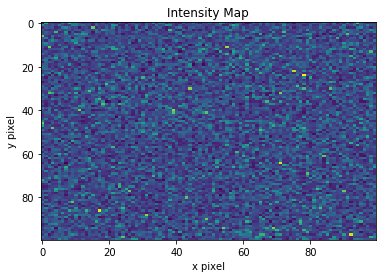

This map_mean represents the intensity map as seen from our sample region.



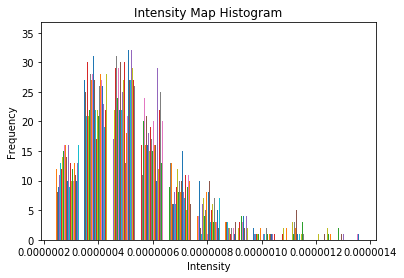

Distribution of intensities of the pixels.

Some (maybe 10, maybe not) of the brighest pixels:

Pixel Index:	Intensity:
(2,15)   	1.3455423153361077e-06
(6,0)   	1.3740779988237005e-06
(11,2)   	1.357943187110985e-06
(11,55)   	1.4928993381822663e-06
(22,75)   	1.5613290862821639e-06
(24,78)   	1.7150147837303993e-06
(30,44)   	1.43283448307993e-06
(32,71)   	1.3882962357102737e-06
(40,11)   	1.3979951690535828e-06
(40,39)   	1.4319550583176723e-06
(46,0)   	1.3600562409642343e-06
(64,71)   	1.6306277587027538e-06
(86,17)   	1.6428203248610738e-06
(88,31)   	1.4385042787913898e-06
(90,49)   	1.3735157513306731e-06
(94,54)   	1.3550478288273384e-06
(94,69)   	1.4061721288838006e-06
(97,92)   	1.6075312068880158e-06


In [11]:
# Analyze the map "map_mean"

# Plot the intensity map
plt.figure(1)
plt.imshow(map_mean, aspect='auto')
plt.title('Intensity Map')
plt.xlabel('x pixel')
plt.ylabel('y pixel')
plt.show()
#plt.clf()

print("This map_mean represents the intensity map as seen from our sample region.\n")

plt.figure(2)
plt.hist(map_mean, bins='auto')
plt.title('Intensity Map Histogram')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.ticklabel_format(style='sci', axis='x')
plt.show()
#plt.clf()
print("Distribution of intensities of the pixels.\n")


# Finding brightest pixels
x_max, y_max = np.where(map_mean > 1.34e-06)
map_max = map_mean[x_max, y_max]
print("Some (maybe 10, maybe not) of the brighest pixels:\n\nPixel Index:\tIntensity:")
for i in range(len(x_max)):
    print("({0},{1})   \t{2}".format(x_max[i],y_max[i],map_max[i]))
    
   
